In [1]:
import pandas as pd
import numpy as nm

#for Label Encoding
from sklearn.preprocessing import LabelEncoder

#for Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for Data splitting
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

# Data Loading

##### 50% - 50% : legitimate links - Malicious links

In [2]:
# Dataset from kaggle (https://www.kaggle.com/shashwatwork/web-page-phishing-detection-dataset)
# 50% - 50% : legitimate URLs - Malicious URLs

df = pd.read_csv("dataset_phishing.csv")
df.shape

(11430, 89)

In [3]:
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


# Pre-processing

##### Dropping duplicate values in dataset

In [4]:
df=df.drop_duplicates(keep='first')

##### Dropping useless columns

In [5]:
df.drop(df.columns.difference(['url','status']), 1, inplace=True)
df.head()

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


##### Encoding status column

In [6]:
status_encoder = LabelEncoder()

status_encoder.fit(df['status'])
df['status_enc'] = status_encoder.transform(df['status'])

df.drop(['status'],axis =1,inplace=True)

# Features Extraction from dataframe

### Lexical based features

##### Count Based features

In [7]:
def count_dots(url): # 1.counting dots in URL
    dot_count = url.count('.')
    return dot_count

def count_hyphen(url): # 2.counting hyphen in URL
    hyphen_count = url.count('-')
    return hyphen_count

def count_underline(url): # 3.counting underline in URL
    underline_count = url.count('_')
    return underline_count

def count_slash(url): # 4.counting slash in URL
    slash_count = url.count('/')
    return slash_count

def count_at(url): # 5.counting @ in URL
    at_count = url.count('@')
    return at_count

def count_and(url): # 6.counting & in URL
    and_count = url.count('&')
    return and_count

def count_equal(url): # 7.counting = in URL
    equal_count = url.count('=')
    return equal_count

def count_question(url): # 8.counting ? in URL
    question_count = url.count('?')

def count_digits(url): # 9.counting digits present in URL
    digit_count = 0
    for i in url:
        if i.isdigit():
            digit_count=digit_count+1
    return digit_count

def count_plus(url): # 10.counting + in URL
    plus_count = url.count('+')
    return plus_count
    
def count_length(url): # 11.counting length of URL 
    #Bucket size : 37 in accordance http://www.supermind.org/blog/740/average-length-of-a-url-part-2
    if len(url)<=37:
        return 0
    elif len(url)>=38 and len(url)<=74:
        return 1
    else:
        return 2

### Extracting URL based features

In [8]:
from urllib.parse import urlparse
import tldextract
import re

In [9]:
def url_scheme(url): # 12.extracting scheme of URL
    scheme = urlparse(url).scheme
    if scheme == 'https':
        return 0
    else:
        return 1

#top 50 subdomains (https://bitquark.co.uk/blog/2016/02/29/the_most_popular_subdomains_on_the_internet)
common_subdomains = {'www','mail','blog','webmail','server','ns1','ns2','smtp','secure','vpn','m','shop','ftp','mail2',
                    'test','portal','ns','ww1','host','support','dev','web','bbs','ww42','mx','email','cloud','1',
                    'mail1','2','forum','owa','www2','gw','admin','store','mx1','cdn','api','exchange','app','gov',
                    '2tty','vps','govyty','hgfgdf','news','1rer','lkjkui'} 

def url_subdomain(url): # 13.extracting subdomain
    subdomain = tldextract.extract(url).subdomain
    if subdomain in common_subdomains:
        return 0
    else:
        return 1

In [10]:
def featureExtraction(url,label):
    features = []
    
    features.append(count_dots(url)) #1
    features.append(count_hyphen(url)) #2
    features.append(count_underline(url)) #3
    features.append(count_slash(url)) #4
    features.append(count_at(url)) #5
    features.append(count_and(url)) #6
    features.append(count_equal(url)) #7
    features.append(count_question(url)) #8
    features.append(count_digits(url)) #9
    features.append(count_plus(url)) #10
    features.append(count_length(url)) #11
    features.append(url_scheme(url)) #12
    features.append(url_subdomain(url)) #13
    
    return features

In [11]:
df.shape

(11430, 2)

In [12]:
selected_features = []
label = 0

for i in range(0, 11430):
    url_value = df['url'][i]
    selected_features.append(featureExtraction(url_value,label))
    
new_labels = ['dot_counts', 'qty_hyphen', 'qty_underline', 'qty_slash', 'qty_at','qty_and', 
                      'qty_equal', 'qty_question', 'qty_digits', 'qty_plus', 'length', 
                      'scheme', 'subdomain']

features_df = pd.DataFrame(selected_features, columns=new_labels)
features_df.head()

,dot_counts,qty_hyphen,qty_underline,qty_slash,qty_at,qty_and,qty_equal,qty_question,qty_digits,qty_plus,length,scheme,subdomain
0,3,0,0,3,0,0,0,None,0,0,0,1,0
1,1,0,0,5,0,0,0,None,17,0,2,1,1
2,4,1,2,5,0,2,3,None,19,0,2,0,1
3,2,0,0,2,0,0,0,None,0,0,0,1,1
4,2,2,0,5,0,0,0,None,0,0,1,1,0


In [13]:
daf = pd.concat([df, features_df], axis=1)

In [14]:
daf.head()

,url,status_enc,dot_counts,qty_hyphen,qty_underline,qty_slash,qty_at,qty_and,qty_equal,qty_question,qty_digits,qty_plus,length,scheme,subdomain
0,http://www.crestonwood.com/router.php,0,3,0,0,3,0,0,0,None,0,0,0,1,0
1,http://shadetreetechnology.com/V4/validation/a...,1,1,0,0,5,0,0,0,None,17,0,2,1,1
2,https://support-appleld.com.secureupdate.duila...,1,4,1,2,5,0,2,3,None,19,0,2,0,1
3,http://rgipt.ac.in,0,2,0,0,2,0,0,0,None,0,0,0,1,1
4,http://www.iracing.com/tracks/gateway-motorspo...,0,2,2,0,5,0,0,0,None,0,0,1,1,0


In [15]:
daf.nunique()

url              11429
status_enc           2
dot_counts          19
qty_hyphen          27
qty_underline       17
qty_slash           22
qty_at               5
qty_and             15
qty_equal           16
qty_question         0
qty_digits         130
qty_plus             9
length               3
scheme               2
subdomain            2
dtype: int64

In [16]:
daf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11430 entries, 0 to 11429
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   url            11430 non-null  object
 1   status_enc     11430 non-null  int32 
 2   dot_counts     11430 non-null  int64 
 3   qty_hyphen     11430 non-null  int64 
 4   qty_underline  11430 non-null  int64 
 5   qty_slash      11430 non-null  int64 
 6   qty_at         11430 non-null  int64 
 7   qty_and        11430 non-null  int64 
 8   qty_equal      11430 non-null  int64 
 9   qty_question   0 non-null      object
 10  qty_digits     11430 non-null  int64 
 11  qty_plus       11430 non-null  int64 
 12  length         11430 non-null  int64 
 13  scheme         11430 non-null  int64 
 14  subdomain      11430 non-null  int64 
dtypes: int32(1), int64(12), object(2)
memory usage: 1.6+ MB


In [17]:
daf.drop(['qty_question'],axis =1,inplace=True)

In [18]:
daf.head()

,url,status_enc,dot_counts,qty_hyphen,qty_underline,qty_slash,qty_at,qty_and,qty_equal,qty_digits,qty_plus,length,scheme,subdomain
0,http://www.crestonwood.com/router.php,0,3,0,0,3,0,0,0,0,0,0,1,0
1,http://shadetreetechnology.com/V4/validation/a...,1,1,0,0,5,0,0,0,17,0,2,1,1
2,https://support-appleld.com.secureupdate.duila...,1,4,1,2,5,0,2,3,19,0,2,0,1
3,http://rgipt.ac.in,0,2,0,0,2,0,0,0,0,0,0,1,1
4,http://www.iracing.com/tracks/gateway-motorspo...,0,2,2,0,5,0,0,0,0,0,1,1,0


##### Encoding URLs to integer datatype

In [19]:
url_encoder = LabelEncoder()

url_encoder.fit(daf['url'])
daf['url_enc'] = url_encoder.transform(daf['url'])

daf.drop(['url'],axis =1,inplace=True)

# Data Visualization

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataframe splitting

In [21]:
Y = daf['status_enc']
X = daf.drop('status_enc',axis=1)
X.shape, Y.shape

((11430, 13), (11430,))

In [22]:
X_train,X_inter_test,Y_train,Y_inter_test = train_test_split(X,Y,test_size=0.2,random_state=0 , shuffle = False)

In [23]:
X_val,X_test,Y_val,Y_test = train_test_split(X_inter_test,Y_inter_test,test_size=0.5,random_state=0 , shuffle = False)

In [24]:
X_train.shape , X_val.shape , X_test.shape

((9144, 13), (1143, 13), (1143, 13))

In [25]:
Y_train.shape , Y_val.shape , Y_test.shape

((9144,), (1143,), (1143,))

# Model Training

In [26]:
daf.head()

,status_enc,dot_counts,qty_hyphen,qty_underline,qty_slash,qty_at,qty_and,qty_equal,qty_digits,qty_plus,length,scheme,subdomain,url_enc
0,0,3,0,0,3,0,0,0,0,0,0,1,0,4501
1,1,1,0,0,5,0,0,0,17,0,2,1,1,3063
2,1,4,1,2,5,0,2,3,19,0,2,0,1,8984
3,0,2,0,0,2,0,0,0,0,0,0,1,1,2778
4,0,2,2,0,5,0,0,0,0,0,1,1,0,5261


In [27]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(random_state=0 , max_depth=8)

classifier.fit(X_train, Y_train)

Y_predict = classifier.predict(X_val)

In [28]:
from sklearn.metrics import accuracy_score

Y_test_tree = classifier.predict(X_test)
Y_train_tree = classifier.predict(X_train)

acc_train_tree = accuracy_score(Y_train,Y_train_tree)

print("Decision Tree Accuracy (training data) : ", acc_train_tree)

Decision Tree Accuracy (training data) :  0.8476596675415573


In [29]:
daf

,status_enc,dot_counts,qty_hyphen,qty_underline,qty_slash,qty_at,qty_and,qty_equal,qty_digits,qty_plus,length,scheme,subdomain,url_enc
0,0,3,0,0,3,0,0,0,0,0,0,1,0,4501
1,1,1,0,0,5,0,0,0,17,0,2,1,1,3063
2,1,4,1,2,5,0,2,3,19,0,2,0,1,8984
3,0,2,0,0,2,0,0,0,0,0,0,1,1,2778
4,0,2,2,0,5,0,0,0,0,0,1,1,0,5261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,0,2,0,0,4,0,0,0,0,0,1,1,0,4876
11426,1,5,0,0,5,1,0,1,2,0,2,1,0,4285
11427,0,2,6,1,5,0,0,1,15,0,2,0,0,9916
11428,0,2,0,0,3,0,0,0,0,0,1,1,0,5705


<AxesSubplot:>

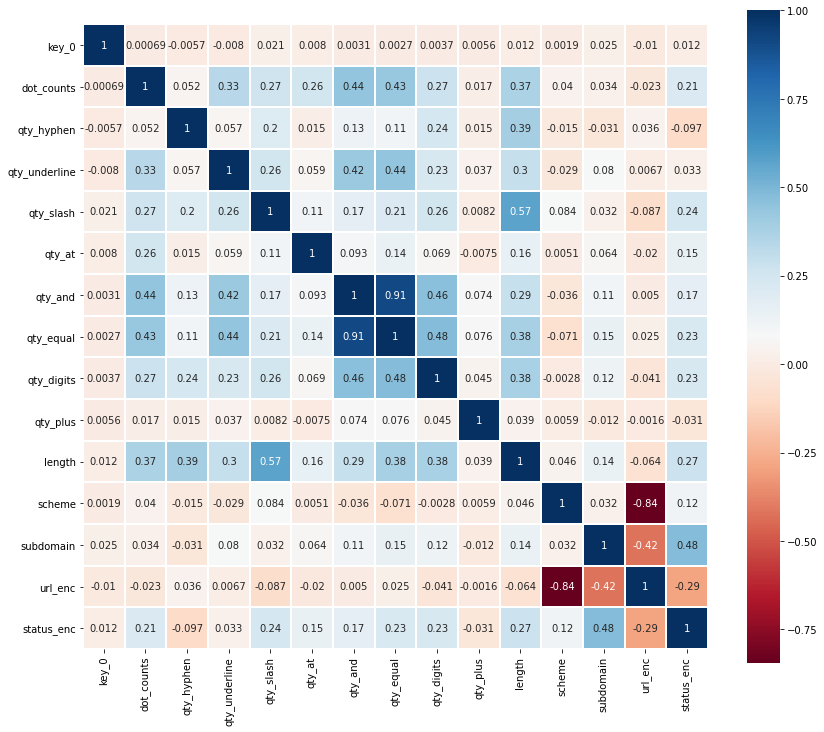

In [30]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('', y=1.05, size=15)
sns.heatmap(X_train.merge(Y_train , on = X_train.index ).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)